### The input is a file with format: timestamp, personId, x, y
#### Change randomized so that the id's change also

#### make correlated groups of people

 


In [40]:
import numpy as np
init_timestamp = 1436047260000
beta = (60/55)*60*1000 # in ms, according to the paper Freudiger 2015, mean time delay between packets
sigma_est = 3
half_dist_teleport =10
sigma_teleport = 3
measurement_delay = 1000 # in ms
randomized_probability = 0.15
path_original_positions = "F:/Arena_sim_data/original_positions_size_"
path_fake_positions = "F:/Arena_sim_data/fake_positions_size_"

In [41]:
def generate_first_moment_visible(crowd_size): #initialization      
    next_moment =[]
    for i in range(0, crowd_size):
        delay = np.random.exponential(beta)
        next_moment.append(int(init_timestamp  + delay))    
    return next_moment    

In [42]:
next_moment = generate_first_moment_visible(3)
next_moment

[1436047291022, 1436047295440, 1436047268532]

In [43]:
def gen_next_moment(timestamp_now): # next moment is drawn from exponential(1/beta) distribution
    delay = np.random.exponential(beta)+1# avoid 0
    return int(timestamp_now + delay)

In [44]:
next_mom = gen_next_moment(3)

In [45]:
next_mom

48086

In [46]:
def make_new_record(record, new_position, randomized):#record = [timestamp, personId, x, y], new_position = [x,y]
    sigma_x =  np.random.exponential(sigma_est)
    sigma_y =  np.random.exponential(sigma_est)
    new_record = {}
    new_record["measurementTimestamp"] = record[0]
    new_record["value"] = {}
    new_record["value"]["sourceMac"] = record[1]
    new_record["value"]["averagecoordinate"] = {}
    new_record["value"]["averagecoordinate"]["avg"] = {}
    new_record["value"]["averagecoordinate"]["avg"]["coordinates"] =[new_position[0], new_position[1], 0.0]
    new_record["value"]["averagecoordinate"]["error"] = {}
    new_record["value"]["averagecoordinate"]["error"]["coordinates"] = [sigma_x, sigma_y, 1000.0]#in the real data for z is 1000
    new_record["value"]["trackeeHistory"]={}
    new_record["value"]["trackeeHistory"]["localMac"] = randomized
    return new_record

In [47]:
b = make_new_record([0,1,3,4], [5,6], 0)

In [48]:
b

{'measurementTimestamp': 0,
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [1.4279727686971102, 0.4850774054460899, 1000.0]}},
  'sourceMac': 1,
  'trackeeHistory': {'localMac': 0}}}

In [49]:
def generate_randomized(crowd_size):
    randomized = [0 for i in range(0, crowd_size)]
    for i in range(0, crowd_size):
        r = np.random.rand()
        if r < randomized_probability:
            randomized[i] = 1
    return randomized

In [50]:
randomized = generate_randomized(10)

In [51]:
randomized


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [52]:
def draw_new_coordinate(position, modes_half_distance=10.0, sigma=5.0):
    rand_mode = np.random.rand()
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    mu = position + rand_mode*modes_half_distance
    new_pos = np.random.normal(mu, sigma)
    return new_pos
    

In [53]:
def create_teleportation_effect_single(record, modes_half_distance, sigma):            
        record_x = draw_new_coordinate(record[2], modes_half_distance, sigma)
        record_y = draw_new_coordinate(record[3], modes_half_distance, sigma)
        return [record_x, record_y]

In [54]:
def make_fake_data(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    next_moment = generate_first_moment_visible(crowd_size)
    randomized = generate_randomized(crowd_size)
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]
        if next_moment[person] > timestamp-measurement_delay and next_moment[person] <= timestamp:#timestamp
                new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
                fake_record = make_new_record(record, new_position, randomized[person])
                fake_positions.append(fake_record)                
                next_moment[person] = gen_next_moment(next_moment[person])
    return fake_positions            

In [55]:

def get_max_velocity(crowd_density):#by Weidmann's equation
    rho = crowd_density+0.00001 #avoid division by 0
    v_0=1.34 #speed at 0 density
    gamma = 1.913 #fit parameter
    rho_max = 5.4 #at this density movement is not possible
    v =v_0*(1-np.exp(-gamma*(1/rho-1/rho_max)))
    v = max(0, v)
    return v

In [56]:
from scipy.stats import norm
def create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []    
    i = 0
    dt = measurement_delay/1000#from ms to s
    density = crowd_size/(width_stadium*length_stadium)#should be the local ideally
    velocity = get_max_velocity(density)
    delta =velocity*dt  #for the brownian motion, how many meters per dt:    
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(0, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            new_x = old_x + norm.rvs(scale=delta**2*dt)
            new_y = old_y + norm.rvs(scale=delta**2*dt)
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                positions.append([init_timestamp+ timestamp, person, new_x, new_y])    
            else:
                positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [57]:
import json

def write_fake_positions(positions,filename):
    file = open(filename, 'w')
    file.close()
    with open(filename, 'a') as outfile:
        for record in positions:
            json.dump(record, outfile)  
            outfile.write("\n")
        

In [58]:
import pickle

def write_original_positions(positions, filepath):   
    with open(filepath, 'wb') as fp:
        pickle.dump(positions, fp)

In [59]:

def read_original_positions( filepath):   
    with open(filepath, 'rb') as fp:
        positions = pickle.load(fp)
    return positions    

In [60]:
def makedata(crowd_size, step, howmany):
    #crowd_size = 65000
    #step = 5000
    for i in range(0, howmany):
        crowd_size = crowd_size + step     
        print(crowd_size)
        positions = create_positions(init_timestamp, crowd_size, 300*1000 , 105, 68)#300 sec
        write_original_positions(positions, path_original_positions + str(crowd_size)+".pkl")
        fake_positions = make_fake_data(crowd_size, positions)
        write_fake_positions(fake_positions, path_fake_positions + str(crowd_size)+".json")        

In [61]:
#makedata(0, 5000, 15)

In [62]:
#fake_positions = make_fake_data(crowd_size, positions)

In [63]:
#fake_positions

In [64]:
np.random.rand()

0.41347625117985654

In [65]:
#positions =  create_positions(10, 2, 105, 68)

In [66]:
#print(positions)

In [67]:
def create_teleportation_effect(positions, modes_distance, sigma):
    for record in positions:
        record[2] = draw_new_coordinate(record[2], modes_distance, sigma)
        record[3] = draw_new_coordinate(record[3], modes_distance, sigma)
    return positions    

In [68]:
#positions = create_teleportation_effect(positions, 10, 5)
#print(positions)

In [69]:
def get_a_snapshot(positions,  timestamp, interval):
    if interval==0:
        snapshot = []        
        for position in positions:
            if position[0] == timestamp:
                snapshot.append(position)            
    else:
        snapshot = []        
        counted = {}
        for position in positions:
            if position[0] > timestamp and position[0] < timestamp + interval*1000:
                if position[1] not in counted:
                    snapshot.append(position)
                    counted[position[1]] = True
    return snapshot        

In [70]:
#get_a_snapshot(positions, 0)

In [71]:
def get_crowd_count_in_square(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_center - half_width_x and record[2] < x_center + half_width_x:
            if record[3] > y_center - half_length_y and record[3] < y_center + half_length_y:
                crowd_count +=1
    return crowd_count

In [72]:
import pickle
def read_original_positions(filepath):
    return pickle.load(open( filepath, "rb" ))

In [73]:
def read_fake_positions(filepath):
    data = []
    with open(filepath) as f:
        data = f.readlines()
    fake_positions = []
    for line in data:
        jsline = json.loads(line)
        fake_positions.append([jsline["measurementTimestamp"], jsline["value"]["sourceMac"], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][0], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][1]])
    return fake_positions

In [74]:
#fake_positions = read_fake_positions(filepath)

In [75]:
def get_method_crowd_count(crowd_size, cell_x, cell_y, timeperiod):
    filepath = "F:/Arena_sim_data/output/size_"+ str(crowd_size) + "_" 
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    return z_data[cell_x][cell_y]
    

In [76]:
b = get_method_crowd_count(10000, 6, 6, 8)

In [77]:
b

24.431435156327058

In [78]:
def run( width_stadium, length_stadium, square_half_size, window, stride):
    errors = []
    differences = []
    scatter = []
    scatter_method = []
    crowd_size = 0
    step = 5000
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    for i in range (0, 15):
        crowd_size +=step
        print(i)
        positions = read_original_positions(path_original_positions + str(crowd_size)+".pkl")
        print(crowd_size)        
        center_x = 32.5 - width_stadium/2.0
        center_y = 32.5 - length_stadium/2.0
        original_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, positions, crowd_size, center_x, center_y, square_half_size, square_half_size, 2*measurement_delay/1000) 
        original_proportion = original_crowd_count/crowd_size
        positions = []
        fake_positions = read_fake_positions(path_fake_positions + str(crowd_size) + ".json")
        #print(fake_positions[0])
        fake_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, fake_positions, crowd_size, center_x, center_y, square_half_size, square_half_size, 60)
        new_proportion = fake_crowd_count/crowd_size
        diff= new_proportion-original_proportion
        differences.append(diff)
        error= fake_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count+0.0001)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
        fake_positions = []
        method_crowd_count = 1.176*get_method_crowd_count(crowd_size, 6, 6, window)
        method_error = method_crowd_count - original_crowd_count
        method_relative_error = method_error/(original_crowd_count+0.0001)
        scatter_method.append([original_crowd_count, method_relative_error ])    
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [errors, differences, scatter, scatter_method,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [79]:
makedata(0, 5000, 16)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000


def runFakePositions(time_interval, width_stadium, length_stadium, square_half_size):
    errors = []
    differences = []
    scatter = []
    crowd_size = 3000
    for i in range (0, 23):
        crowd_size = int(crowd_size * 1.12)
        positions = create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium)
        print(positions[0])
        center_x = 32.5 #width_stadium/2.0
        center_y = 32.5 #length_stadium/2.0
        original_crowd_count = get_crowd_count_in_square(init_timestamp, positions, crowd_size, center_x, center_y, square_half_size, square_half_size) 
        original_proportion = original_crowd_count/crowd_size
        positions = create_teleportation_effect(positions, 10, 5)
        new_crowd_count = get_crowd_count_in_square(init_timestamp, positions, crowd_size, center_x, center_y, square_half_size, square_half_size)
        new_proportion = new_crowd_count/crowd_size
        diff= new_proportion-original_proportion
        differences.append(diff)
        error= new_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count+0.01)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
    lists = [errors, differences, scatter]    
    return lists  

In [41]:
lists = run( 105.0, 68.0, 2.5, 8, 30)

0
5000
Original crowd count:23
Fake crowd count:5
Method crowd count:12.0535689098
1
10000
Original crowd count:41
Fake crowd count:16
Method crowd count:28.7313677438
2
15000
Original crowd count:37
Fake crowd count:28
Method crowd count:52.9404762286
3
20000
Original crowd count:64
Fake crowd count:48
Method crowd count:74.2793757798
4
25000
Original crowd count:98
Fake crowd count:49
Method crowd count:87.4706457559
5
30000
Original crowd count:125
Fake crowd count:65
Method crowd count:112.457705143
6
35000
Original crowd count:113
Fake crowd count:80
Method crowd count:122.092618807
7
40000
Original crowd count:127
Fake crowd count:74
Method crowd count:148.033484324
8
45000
Original crowd count:141
Fake crowd count:78
Method crowd count:157.007376712
9
50000
Original crowd count:158
Fake crowd count:97
Method crowd count:175.70313688
10
55000
Original crowd count:248
Fake crowd count:105
Method crowd count:187.417472915
11
60000
Original crowd count:232
Fake crowd count:136
Metho

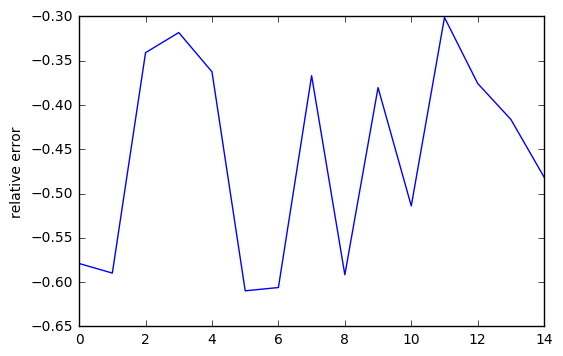

In [41]:
import matplotlib.pyplot as plt
plt.plot(lists[0])
plt.ylabel('relative error')
#plt.xlabel('crowd size (unit:500)')
plt.show()

In [42]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

#n = 50

x = np.array([r[0] for r in lists[2] ])
y = np.array([r[1] for r in lists[2] ])

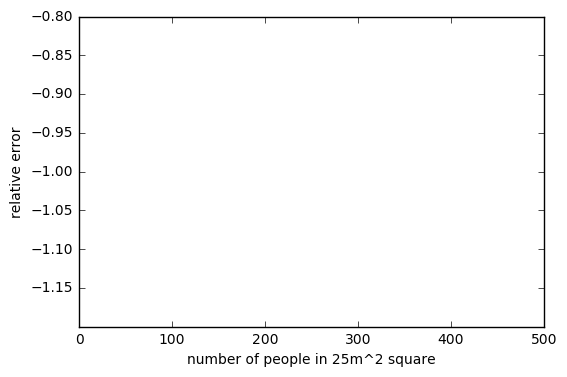

In [43]:
#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


#plt.plot(x, fit[0] * x + fit[1], color='red')
plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('relative error')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([0, 500])
axes.set_ylim([-1.2, -0.8])
plt.show()

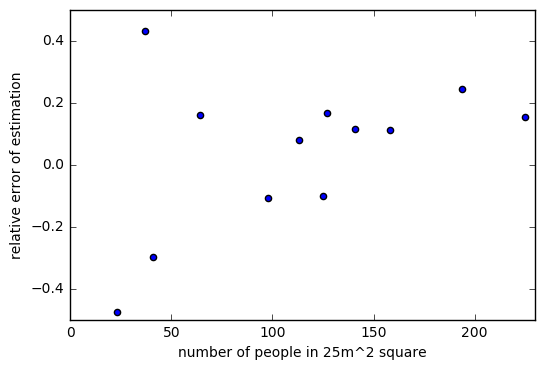

In [48]:

#n = 50

x = np.array([r[0] for r in lists[3] ])
y = np.array([r[1] for r in lists[3] ])

#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


#plt.plot(x, 0, color='red')
plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('relative error of estimation')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([0, 230])
axes.set_ylim([-0.5, 0.5])
plt.show()

In [ ]:
lists[3] 

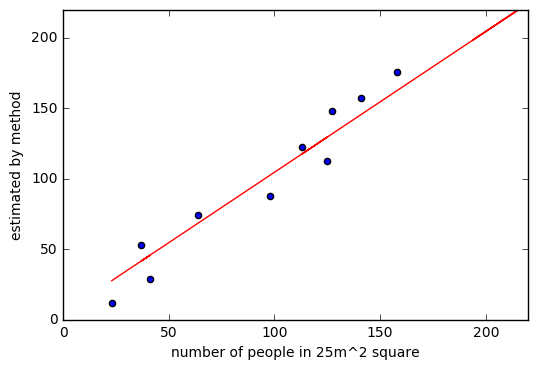

In [43]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
x = np.array([r for r in lists[4] ])
y = np.array([r for r in lists[6] ])

#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


plt.plot(x, fit[0] * x + fit[1], color='red')
#plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('estimated by method')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([0, 220])
axes.set_ylim([0,220])
plt.show()

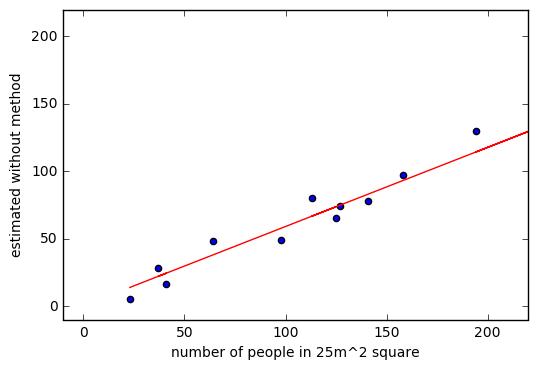

In [44]:
x = np.array([r for r in lists[4] ])
y = np.array([r for r in lists[5] ])

#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


plt.plot(x, fit[0] * x + fit[1], color='red')
#plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('estimated without method')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([-10, 220])
axes.set_ylim([-10,220])
plt.show()